In [5]:
import numpy as np
from matplotlib import pyplot, cm
%matplotlib inline

from tqdm import tqdm
import time

import sys
np.set_printoptions(threshold=sys.maxsize)

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [10]:
g0=4     #Bacterial growth Parameter
gamma=16     #Bacterial growth Parameter
k_value=42.5     #Bacterial growth Parameter

Dc=1e-3
Db=.04

t_ref=20
Xe=.3

X0=1e-3

C0=15
C_thresh_value=1.5

d=20 #separation between inoculum change; check for 5mm, 10mm, 20mm
rho=2.5
mu=40

dx=dy = 0.25

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

gridx,gridy=69,69    # should be odd numbers, keep both numbers equal = 369,369 as per paper
dx=0.25*(369/gridx)
dy=0.25*(369/gridy)

Current time is: Tue Nov  5 16:37:24 2019


In [11]:
X1=np.zeros((gridx,gridy),dtype=np.float64)   # 2-D array 
X2=np.zeros((gridx,gridy),dtype=np.float64)
C=np.zeros((gridx,gridy),dtype=np.float64)
m=np.zeros((gridx,gridy))
C_thresh=np.zeros((gridx,gridy))
k=np.zeros((gridx,gridy))

#(taking x,y for coordinate positions) :
x=np.linspace(-int(gridx/2),int(gridx/2),num=gridx,dtype=int)  #grid positions --> e.g. for 369 grids, numbering would be -184,-183,..,0,..,183,184
y=np.linspace(-int(gridy/2),int(gridy/2),num=gridy,dtype=int)  
x0=np.where(x==0)[0][0]   # x-coordinate of position of Origin 
y0=np.where(y==0)[0][0]
xl=np.linspace(-184*.25,184*.25,num=len(x))      # x-coordinate of each grid point (gives distance from origin in x direction)       
yl=np.linspace(-184*.25,184*.25,num=len(y))

############# Defining Initial Conditions #############
# for X1 and X2
for i in range(len(xl)):
    for j in range(len(yl)):
        if  ((xl[i]-d/2)**2 + yl[j]**2 <= rho**2):
            X1[i,j] = X0
        
        if  (xl[i]+d/2)**2 + yl[j]**2 <= rho**2:
            X2[i,j] = X0


                                                                       #np.savetxt('output.txt',X1,fmt='%.4e')

#Initializing parameters in array for all positional coordinates on 2D grid:
for i in range(len(x)):
    for j in range(len(y)):
        C[i,j]=C0
        C_thresh[i,j]=C_thresh_value
        k[i,j]=k_value



print("Initializing Initial Conditions has been completed")
#######################################################        
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

Initializing Initial Conditions has been completed
Current time is: Tue Nov  5 16:37:25 2019


In [12]:
def H_t(var,value):        # heavy side step function for time & Xe, not for matrix output
    if var-value <0:
        return 0
    if var-value==0:
        return 0.5
    else: return 1

    
def H_pos(mat1,mat2):      # heavy side step function for position, for matrix output of heavy side function values at each grid point
    
    mat3=np.zeros((max(mat1.shape),min(mat1.shape)))
    
    for i in range(max(mat1.shape)):
        for j in range(min(mat1.shape)):
            if mat1[i,j]-mat2[i,j]<0:
                mat3[i,j]=0
            if mat1[i,j]-mat2[i,j]==0:
                mat3[i,j]=0.5
            else: mat3[i,j]=1
    return mat3

def H_xe(Xe,mat2):      # heavy side step function for position, for matrix output of Mortality term which only activates at Origin
   
    mat3=np.zeros((mat2.shape[0],mat2.shape[1]))
    
    if Xe-mat2[0,0] < 0:
            mat3[0,0]=0
    if Xe-mat2[0,0] == 0:
            mat3[0,0]=0.5
    if Xe-mat2[0,0] > 0:
            mat3[0,0]=1
    return mat3


def growth(nt,time_length):  # to be given number of time steps
    
    # nt : number of time-steps -- to be made 5001
    # time_length in hours: duration of time upto which you wish to see the simulation --- to be made 48 hours

    dt=time_length/nt       # time-step size
    print("The growth for time by time step %f for %f hour time length has been completed for:-" %(dt,time_length))
    
    for n in range(nt):
        
        g_c=g0*np.divide(C,np.add(k,C))
        
        m[:,:]=mu*np.multiply(X1[:,:],X2[:,:])*H_xe(Xe,X1+X2)*H_t((n+1)*dt,t_ref)
        X1[1:-1,1:-1]=X1[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X1[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X1[2:,1:-1]-2*X1[1:-1,1:-1]+X1[:-2,1:-1])/dx**2) + ((X1[1:-1,2:]-2*X1[1:-1,1:-1]+X1[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        X2[1:-1,1:-1]=X2[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X2[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X2[2:,1:-1]-2*X2[1:-1,1:-1]+X2[:-2,1:-1])/dx**2) + ((X2[1:-1,2:]-2*X2[1:-1,1:-1]+X2[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        
        C[1:-1,1:-1]= C[1:-1,1:-1] +dt*(-gamma*(np.multiply(g_c[1:-1,1:-1],np.add(X1[1:-1,1:-1],X2[1:-1,1:-1]))) + Dc*(((C[2:,1:-1]-2*C[1:-1,1:-1]+C[:-2,1:-1])/dx**2) + ((C[1:-1,2:]-2*C[1:-1,1:-1]+C[1:-1,:-2])/dy**2)))

        ############# Start: Boundary Conditions ######################
        
        #Neumann Condition: Normal component of Bacterial density on boundary is zero
        
        X1[:][-1] = X1[:][-2]
        X1[:][0]  = X1[:][1] 
        X1[-1][:] = X1[-2][:]
        X1[0][:]  = X1[1][:] 

        
                            # not sure whether it is a right way of doing. Perhaps, it should be opposite way as above calculation stencil never go on edge, so it would remain X0 eternally. But, it should change
        X2[:][-1] = X2[:][-2]
        X2[:][0]  = X2[:][1] 
        X2[-1][:] = X2[-2][:]
        X2[0][:]  = X2[1][:] 

        
        
        #Dirichlet condition: Fixed and Unchanging Concentration of growth media on boundary
        C[0][:]=C[-1][:]=C[:][0]=C[:][-1]=C0
        
        ############# End: Boundary Conditions ######################

        ############ Start: Saving history of Bacterial Density and Growth Media Concentration #########
        
        X1_hist[n+1][:][:]=X1[:][:]
        X2_hist[n+1][:][:]=X2[:][:]
        C_hist[n+1][:][:]=C[:][:]
        
        ############ End: Saving history of Bacterial Density and Growth Media Concentration #########
        
            
        if n%100==0:
            print("%d steps, Wall clock time: "  %n, end="")
            print(time.asctime( time.localtime(time.time())))
        
        
nt=5001
time_length=(48/5001)*nt

X1_hist=np.zeros((nt+1,gridx,gridy))
X2_hist=np.zeros((nt+1,gridx,gridy))
C_hist=np.zeros((nt+1,gridx,gridy))

X1_hist[0][:][:]=X1[:][:]
X2_hist[0][:][:]=X2[:][:]
C_hist[0][:][:]=C[:][:]

growth(nt,time_length)

print("All the step calculations for growth have been completed")  

The growth for time by time step 0.009598 for 48.000000 hour time length has been completed for:-
0 steps, Wall clock time: Tue Nov  5 16:37:26 2019
100 steps, Wall clock time: Tue Nov  5 16:37:32 2019
200 steps, Wall clock time: Tue Nov  5 16:37:36 2019
300 steps, Wall clock time: Tue Nov  5 16:37:40 2019
400 steps, Wall clock time: Tue Nov  5 16:37:45 2019
500 steps, Wall clock time: Tue Nov  5 16:37:51 2019
600 steps, Wall clock time: Tue Nov  5 16:37:54 2019
700 steps, Wall clock time: Tue Nov  5 16:37:59 2019
800 steps, Wall clock time: Tue Nov  5 16:38:04 2019
900 steps, Wall clock time: Tue Nov  5 16:38:08 2019
1000 steps, Wall clock time: Tue Nov  5 16:38:13 2019
1100 steps, Wall clock time: Tue Nov  5 16:38:17 2019
1200 steps, Wall clock time: Tue Nov  5 16:38:22 2019
1300 steps, Wall clock time: Tue Nov  5 16:38:27 2019
1400 steps, Wall clock time: Tue Nov  5 16:38:33 2019
1500 steps, Wall clock time: Tue Nov  5 16:38:38 2019
1600 steps, Wall clock time: Tue Nov  5 16:38:45 2

Plotting figures for Nutrient Media Concentration


TypeError: Length of x must be number of columns in z.

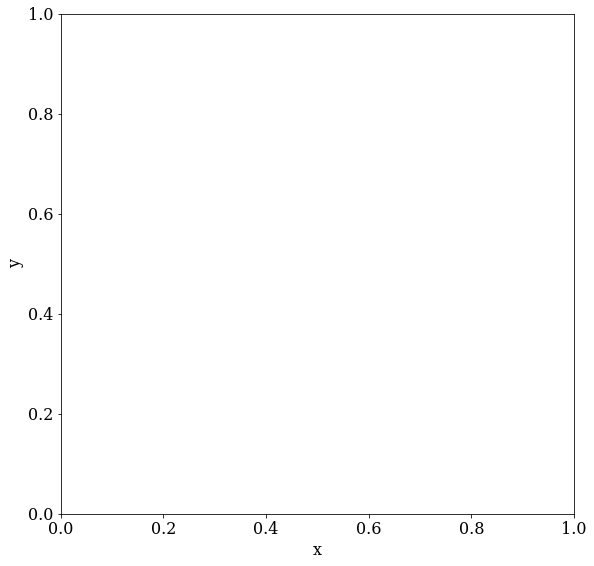

In [17]:
print("Plotting figures for Nutrient Media Concentration")
for i in range(10):
    fig=pyplot.figure(figsize=(9.2,9.2))
    
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, 15, num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, C_hist[i][:][:], levels=levels)
    fig.suptitle('Concentration after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('C after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    fig.savefig('Concentration-%d.jpg'%i)
    ;

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

#pyplot.figure(figsize=(9.2,9.2))
#pyplot.xlabel('x')
#pyplot.ylabel('y')
#levels = np.linspace(0, 100.0, num=51)
#contf = pyplot.contourf(x, y, X2, levels=levels)
#cbar = pyplot.colorbar(contf)
#cbar.set_label('X2 after %nt steps')
#pyplot.axis('scaled', adjustable='box');

Plotting figures for X1 & X2 growth
0
102
204
306
408
510
612
714
816
918
1020
1122
1224
1326
1428
1530
1632
1734
1836
1938


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


2040
2142
2244
2346
2448
2551
2653
2755
2857
2959
3061
3163
3265
3367
3469
3571
3673
3775
3877
3979
4081
4183
4285
4387
4489
4591
4693
4795
4897
5000
Current time is: Tue Nov  5 16:54:34 2019


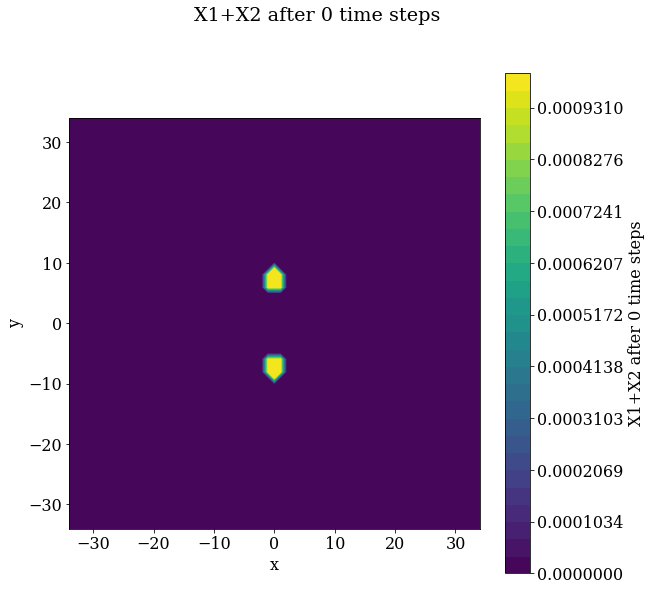

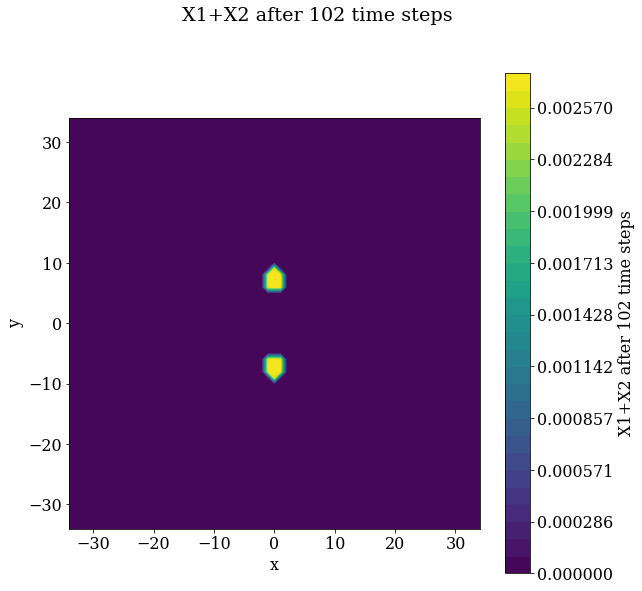

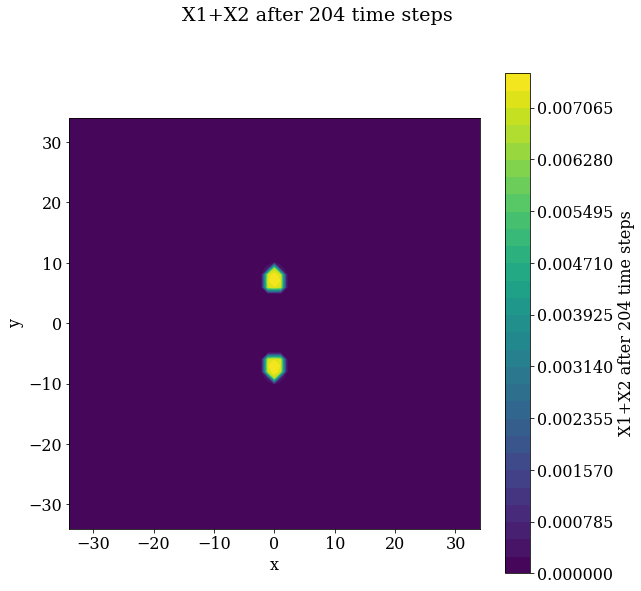

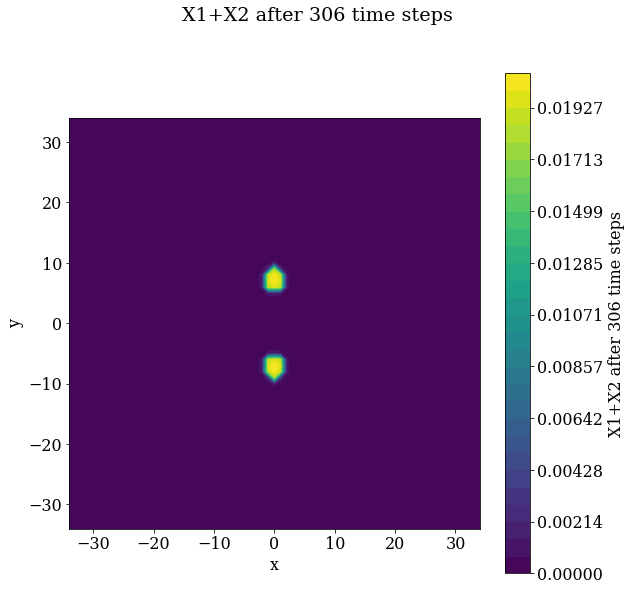

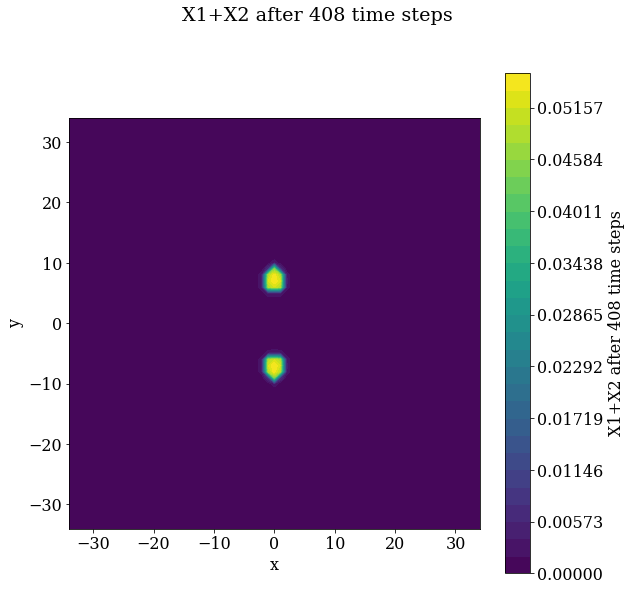

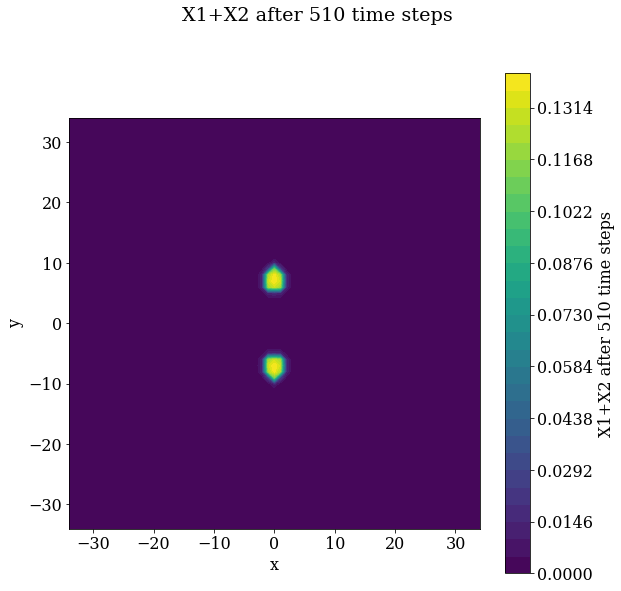

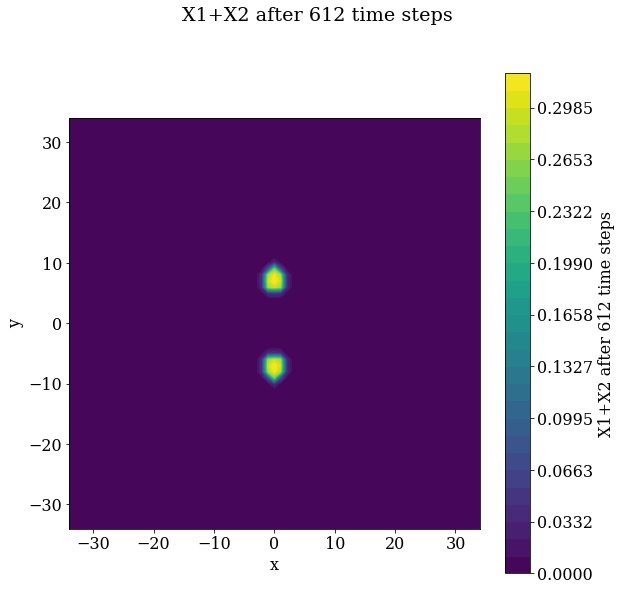

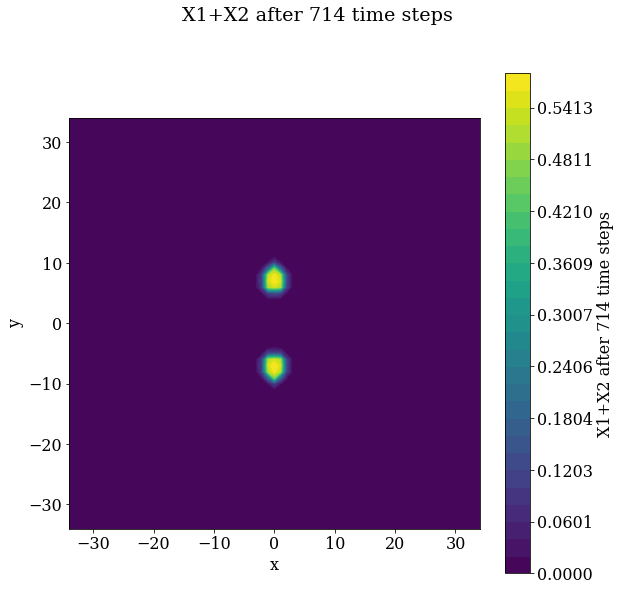

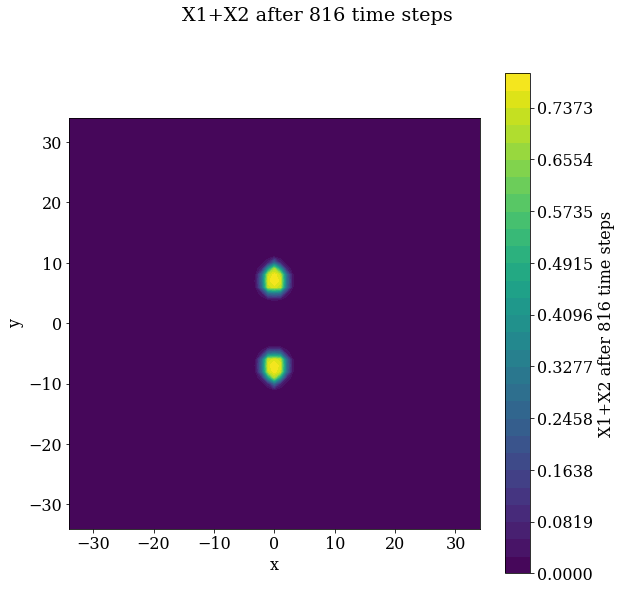

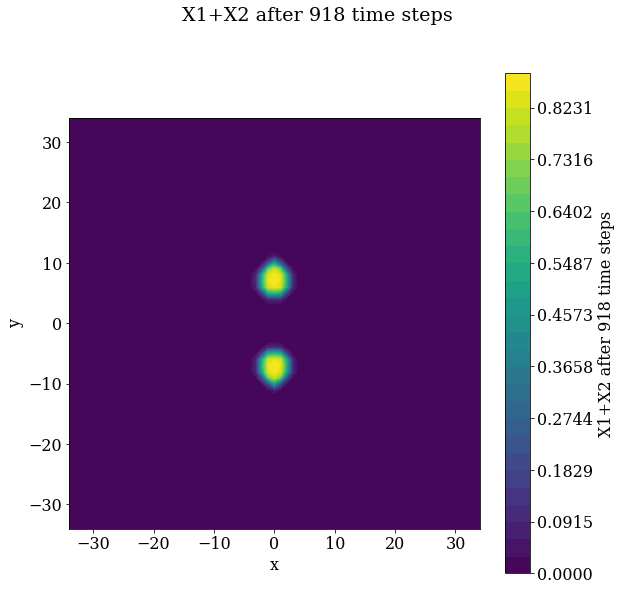

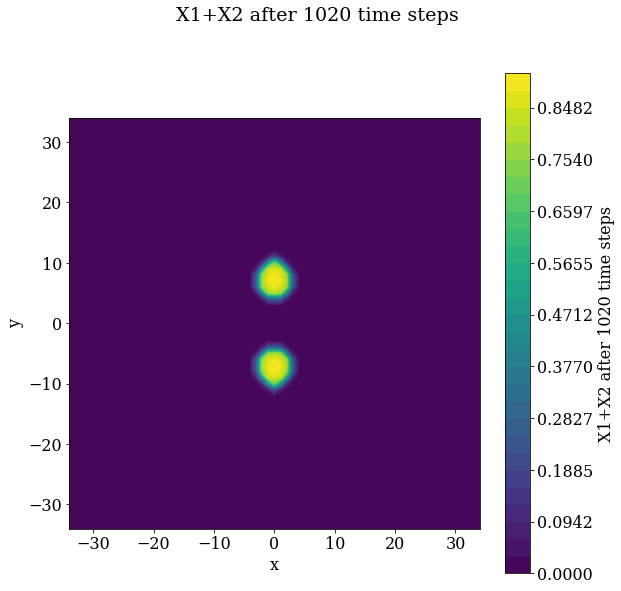

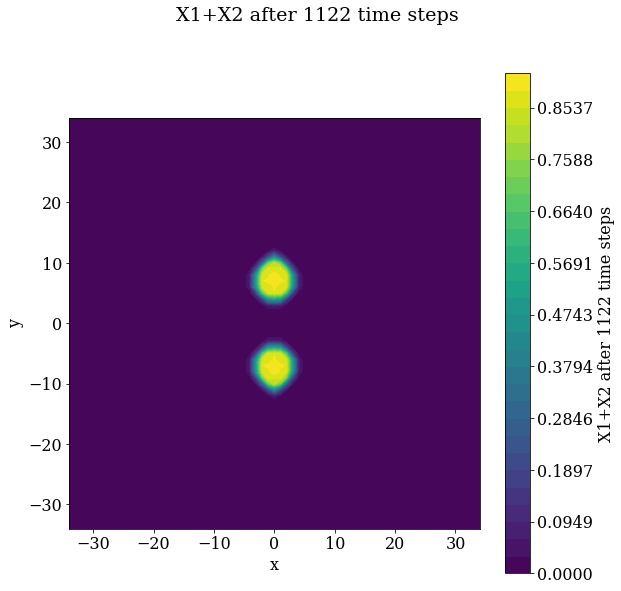

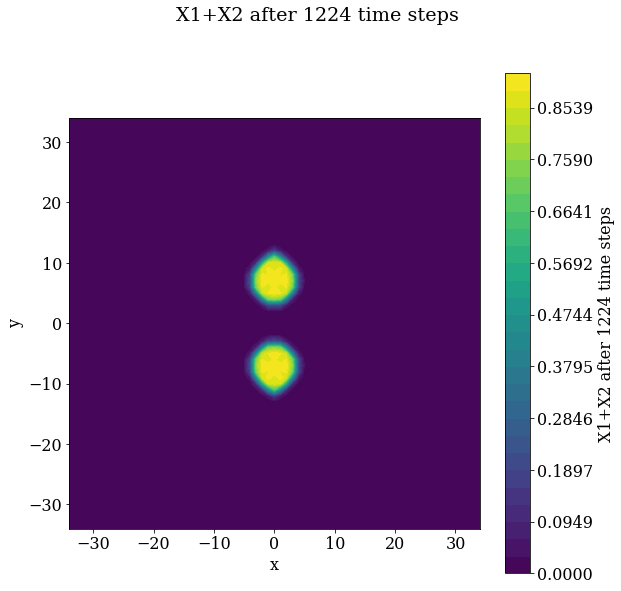

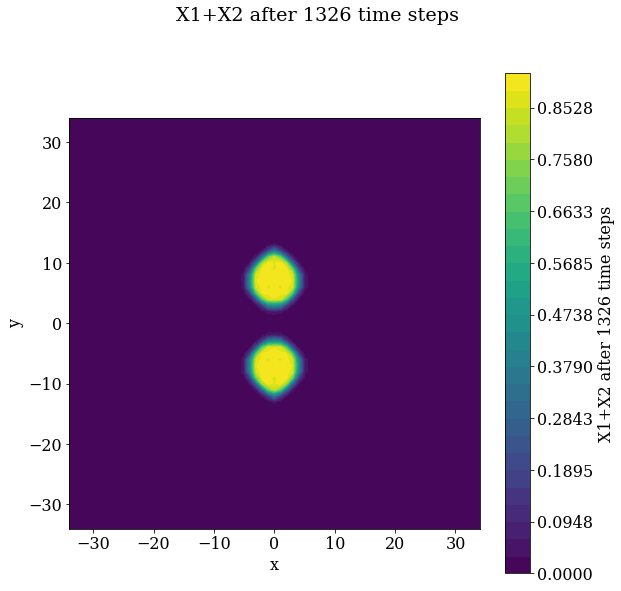

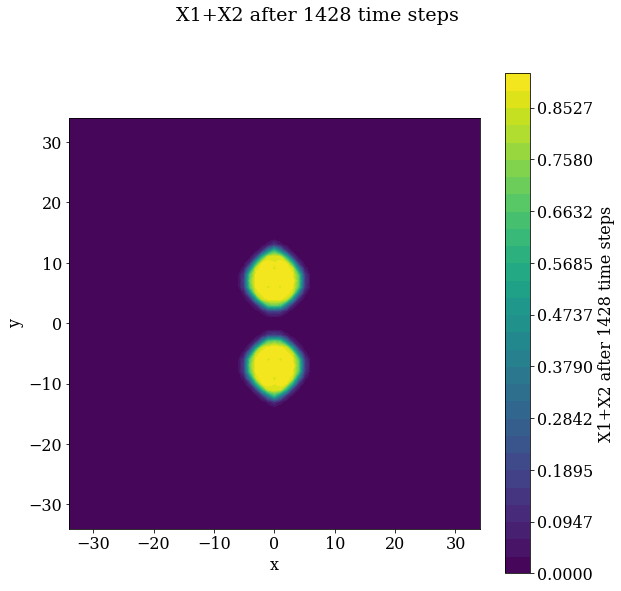

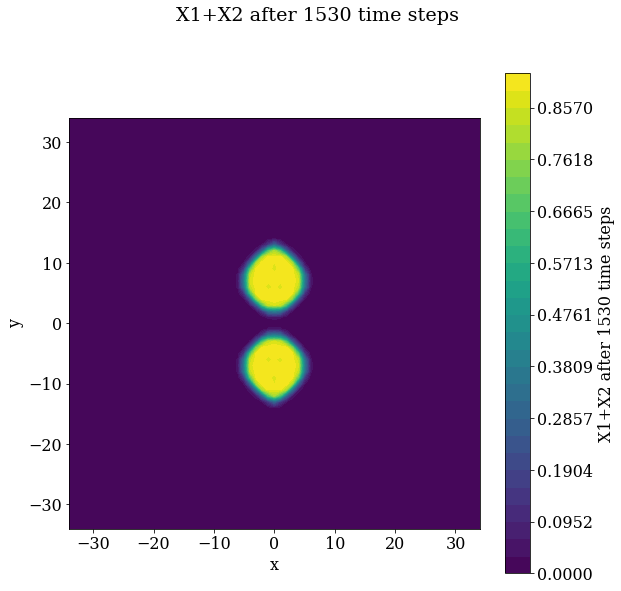

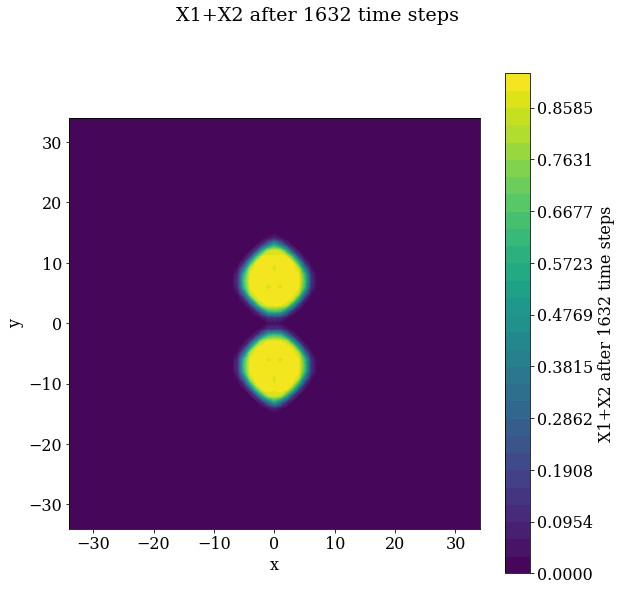

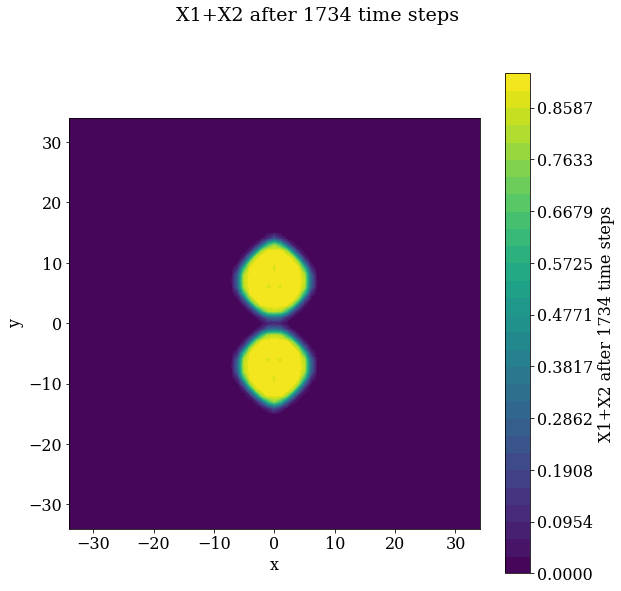

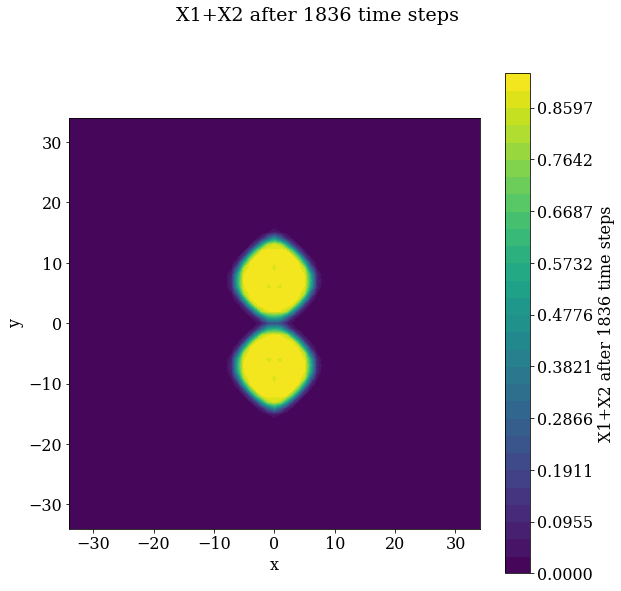

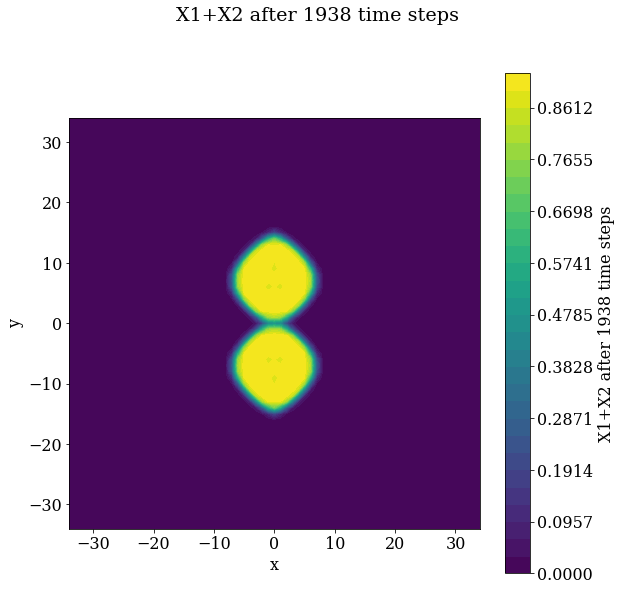

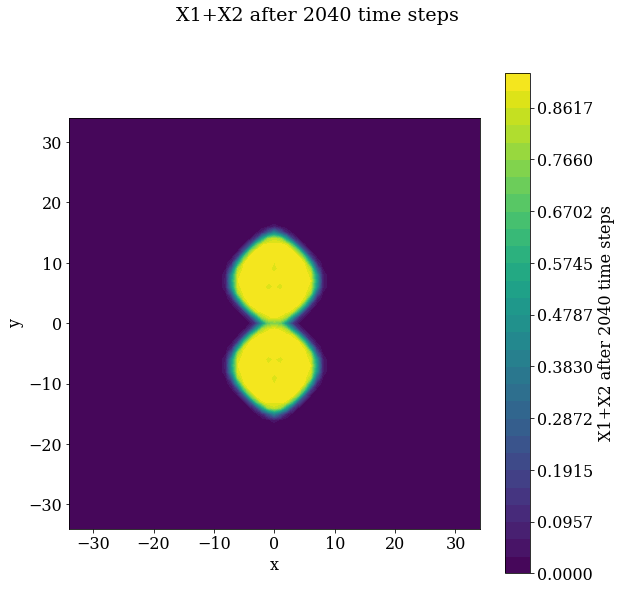

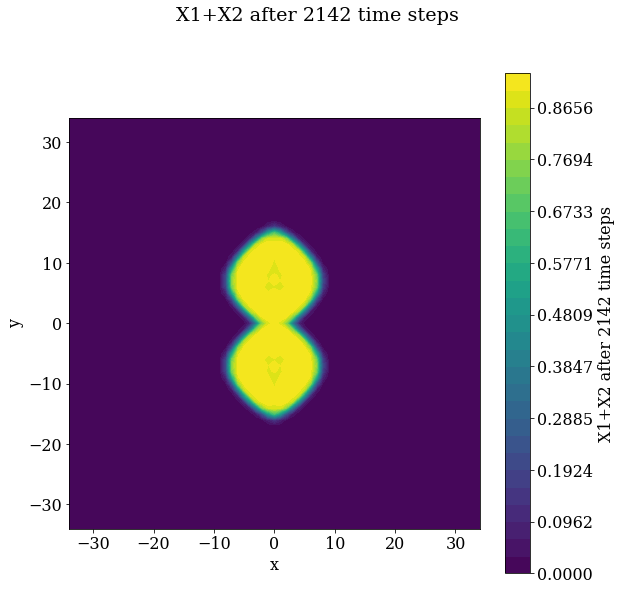

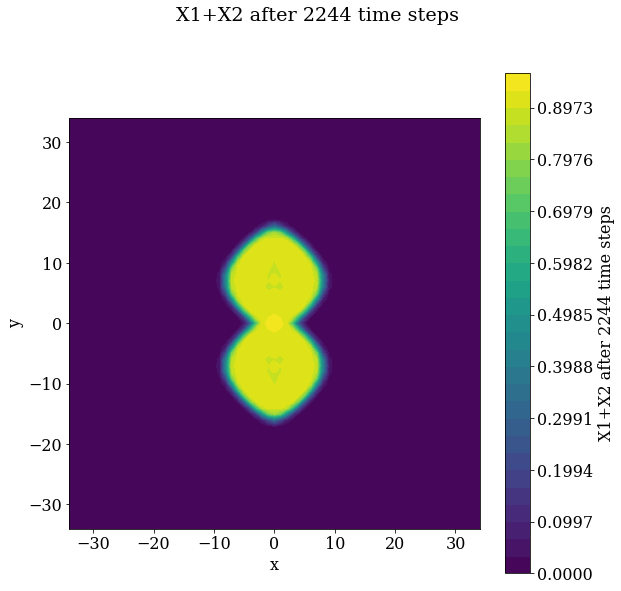

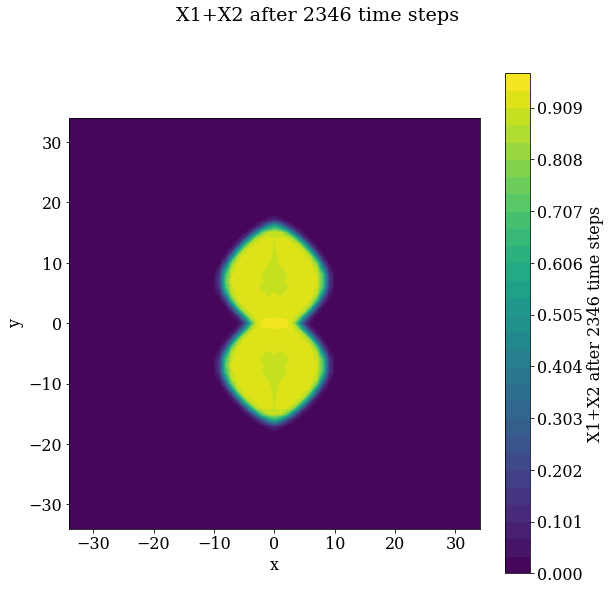

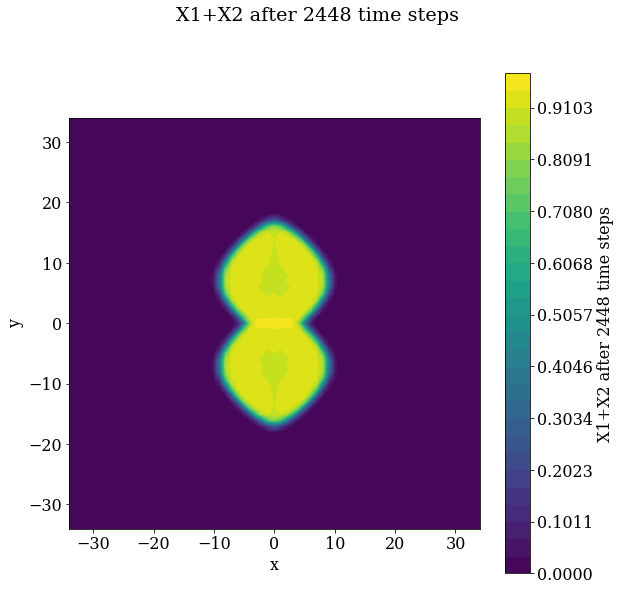

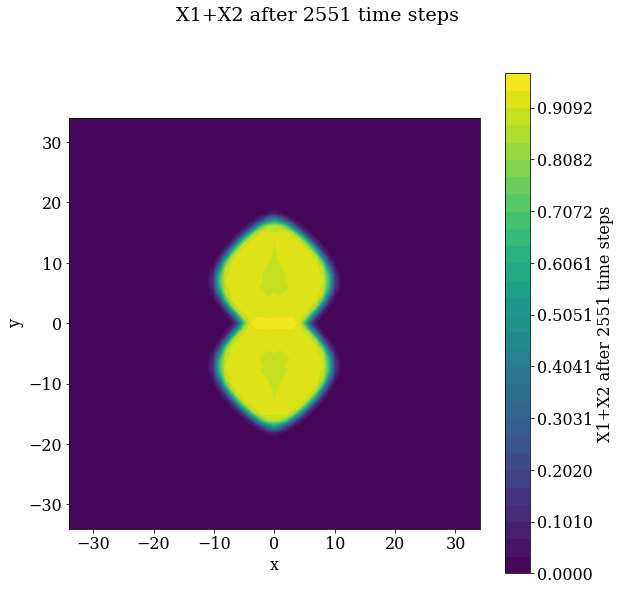

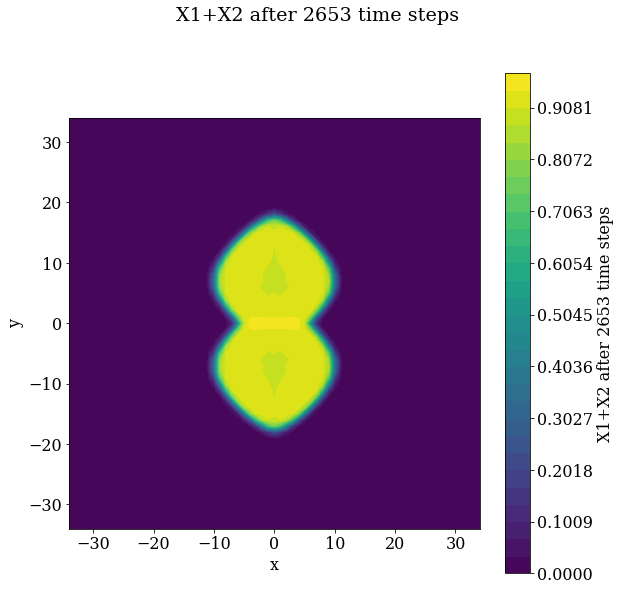

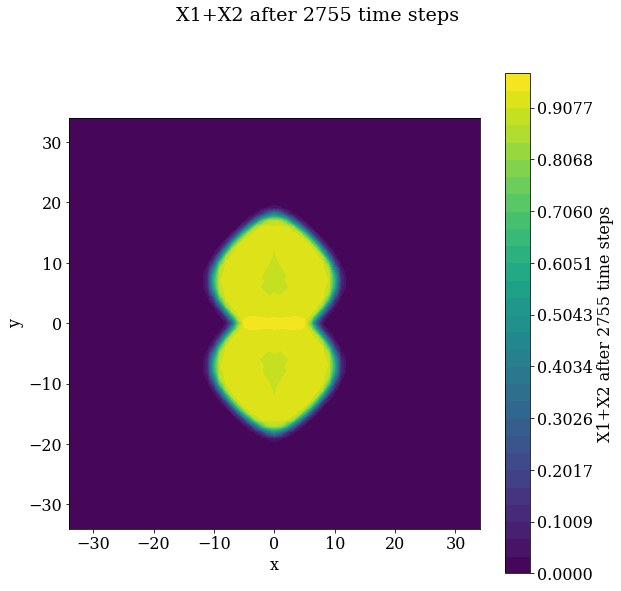

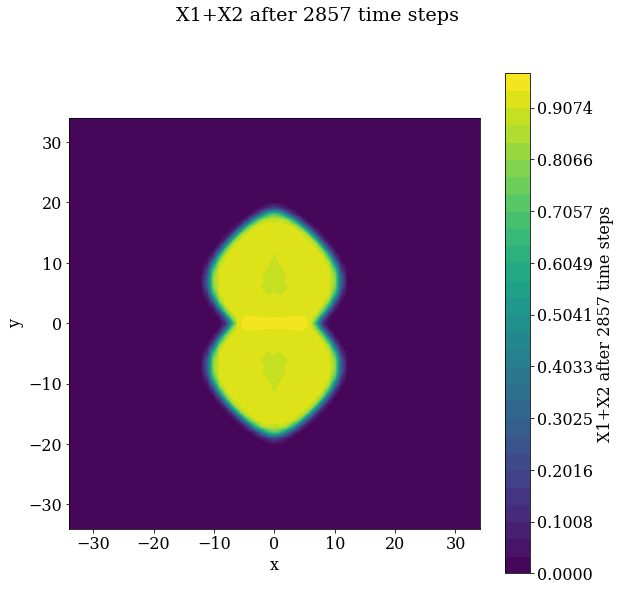

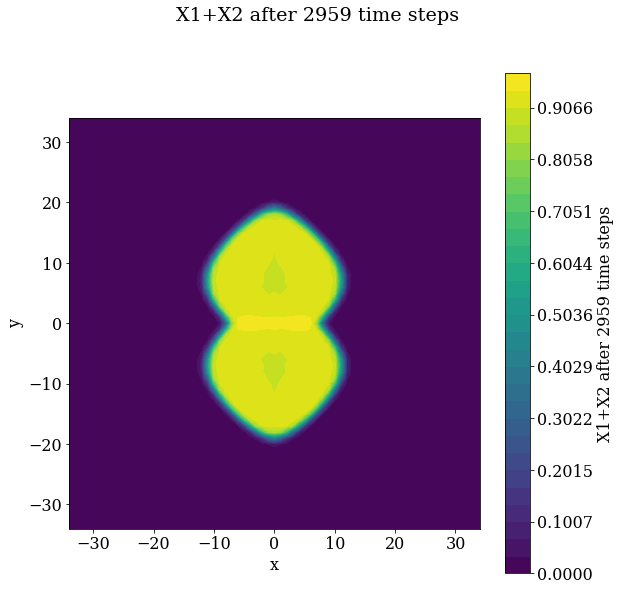

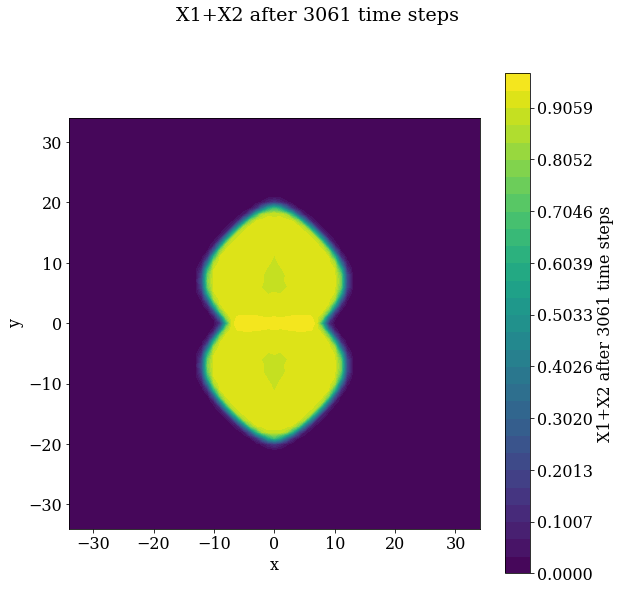

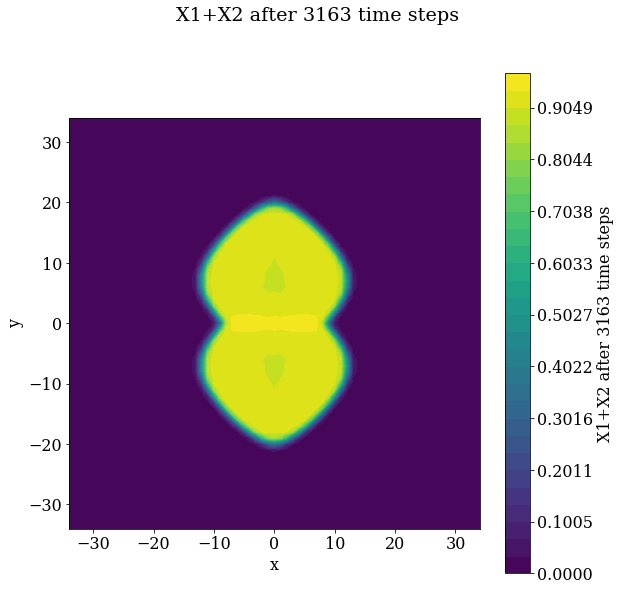

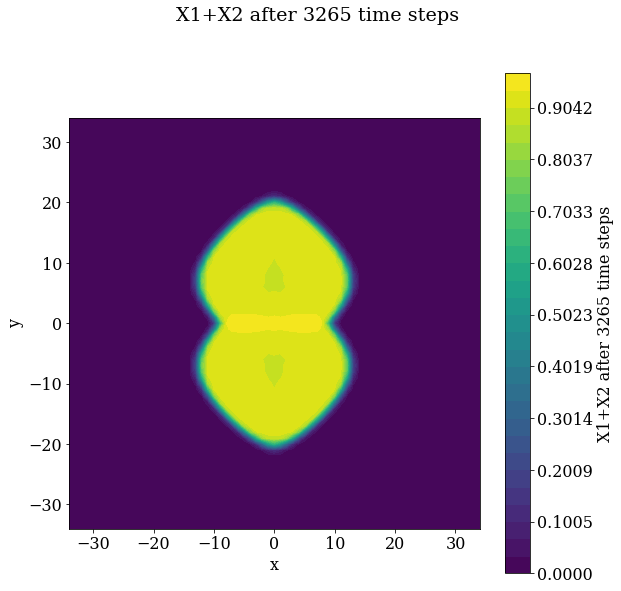

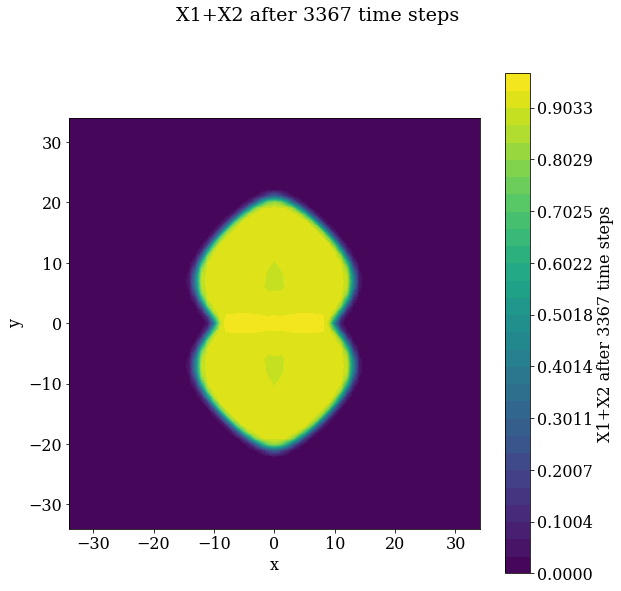

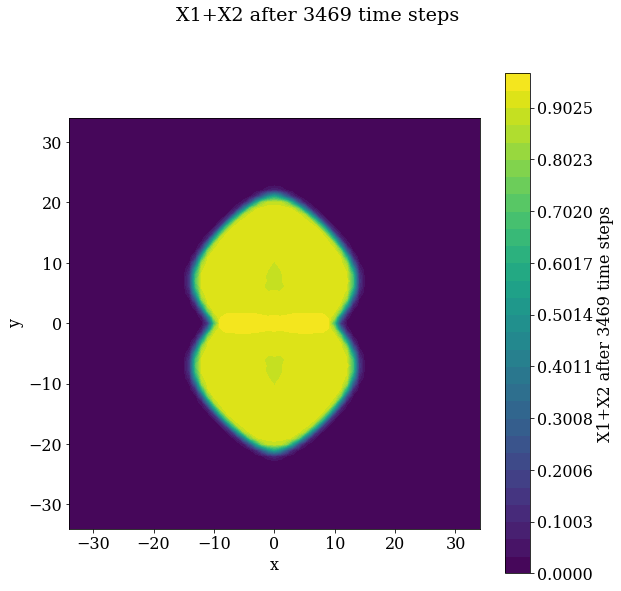

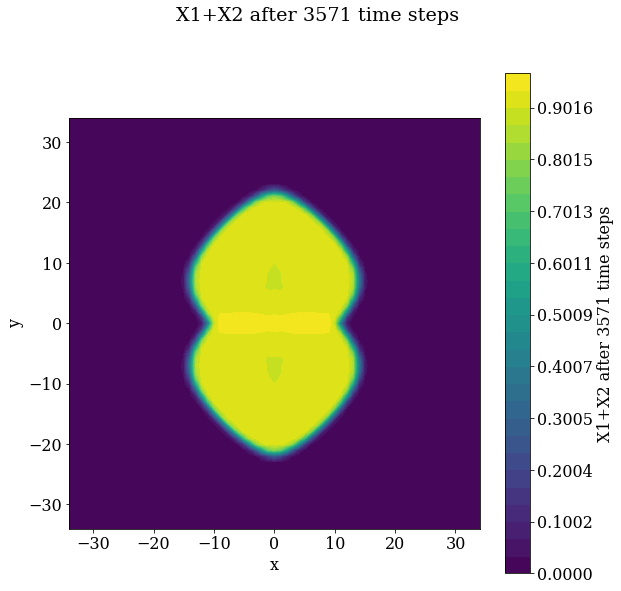

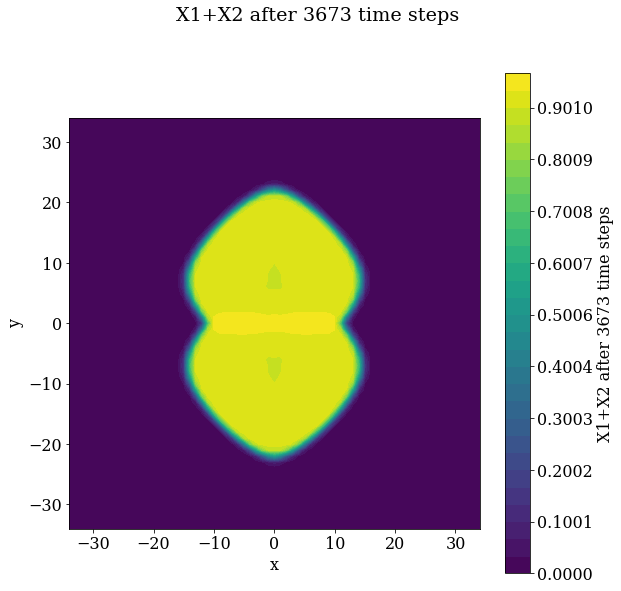

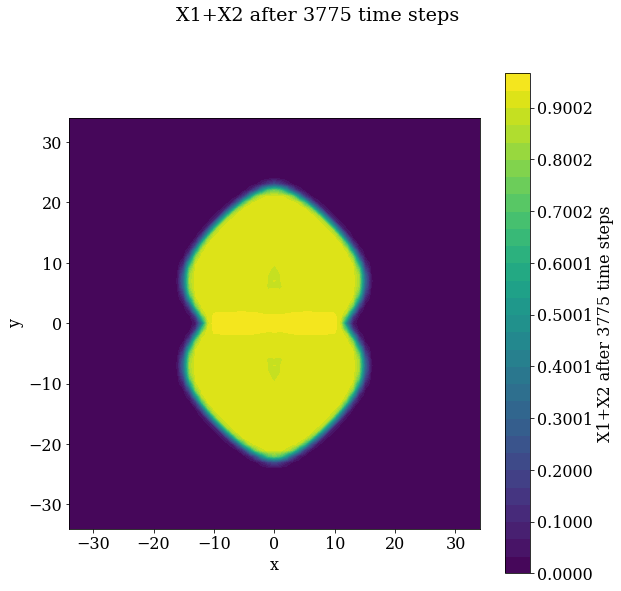

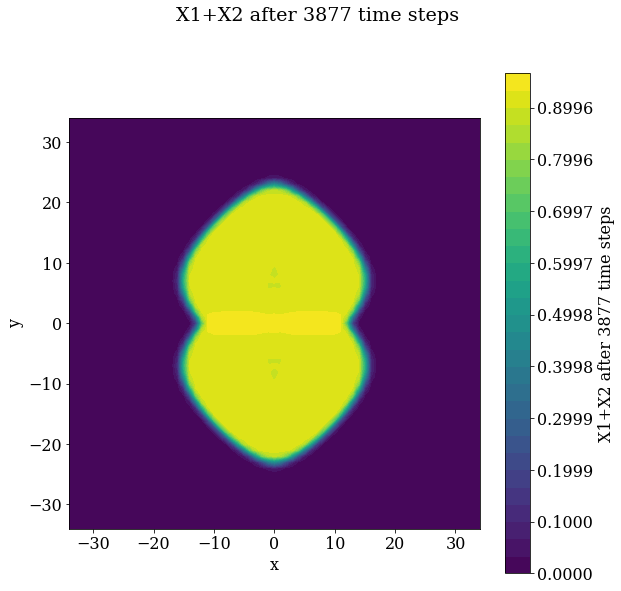

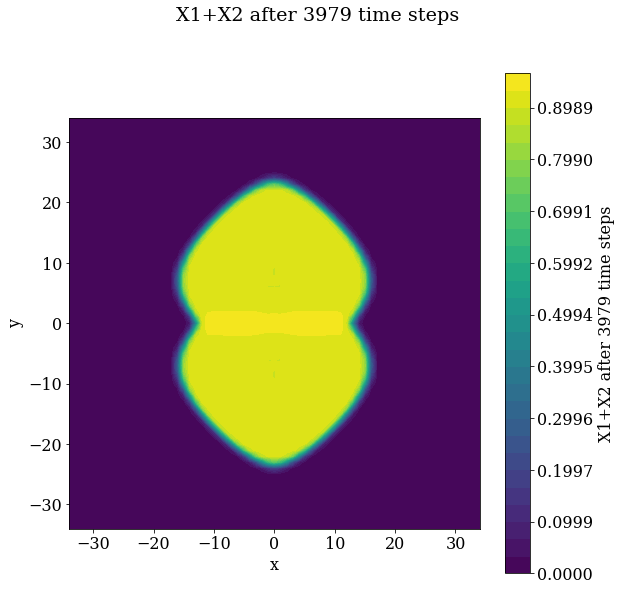

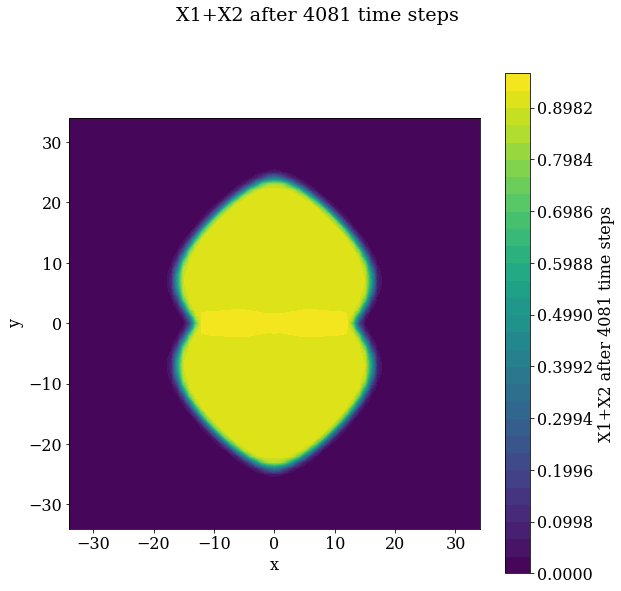

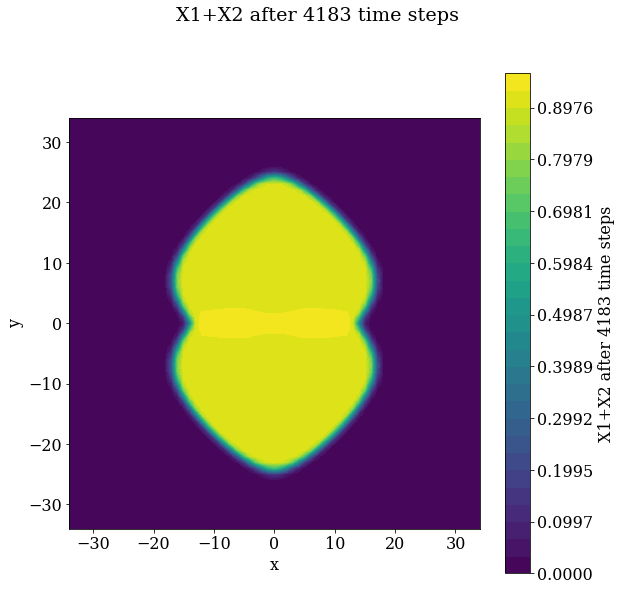

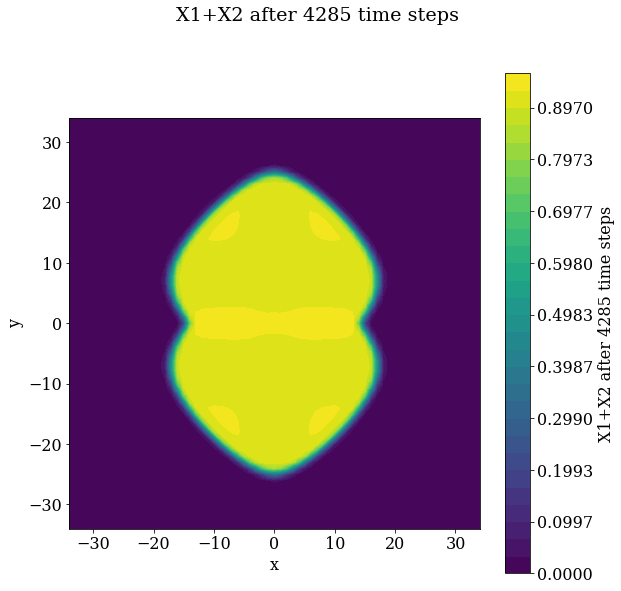

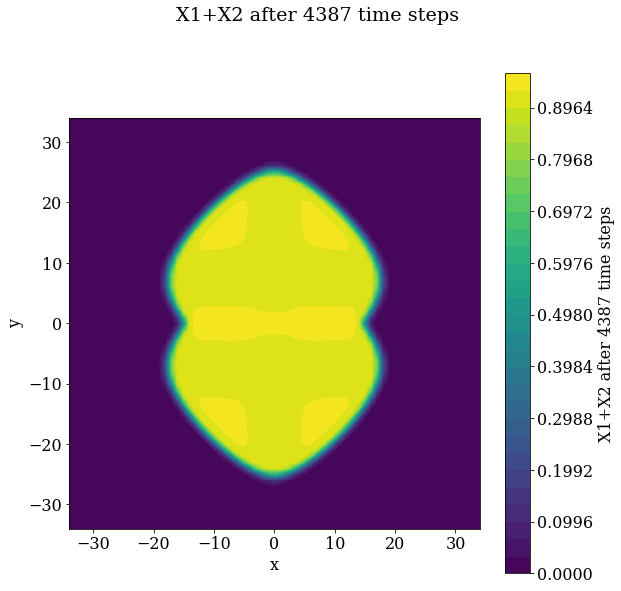

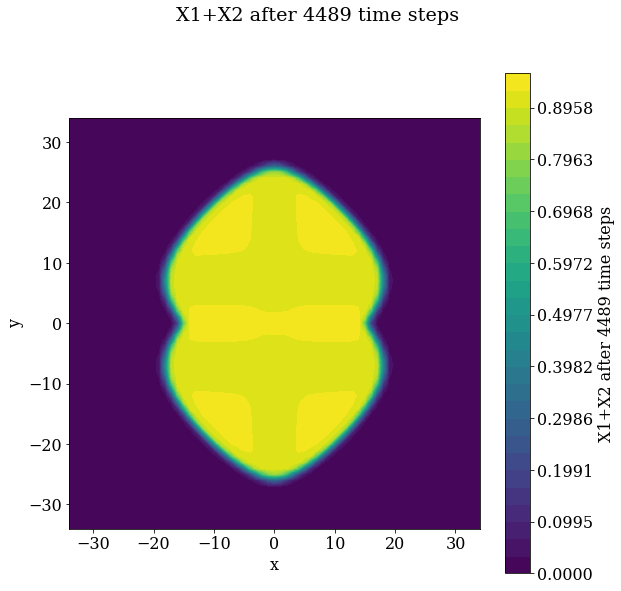

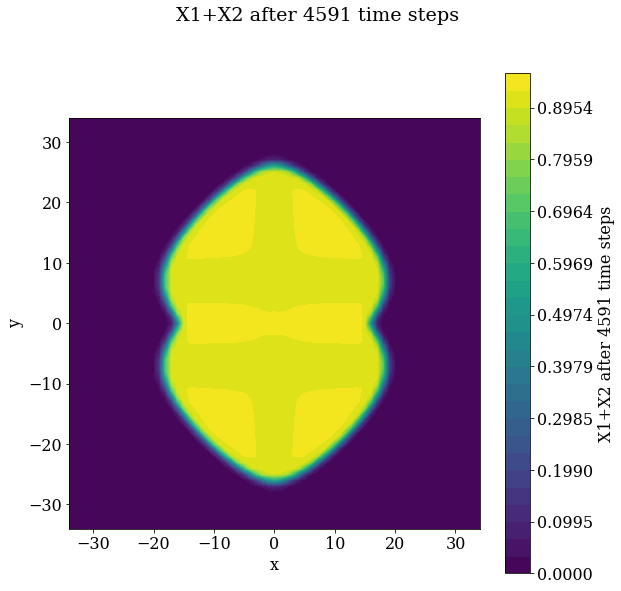

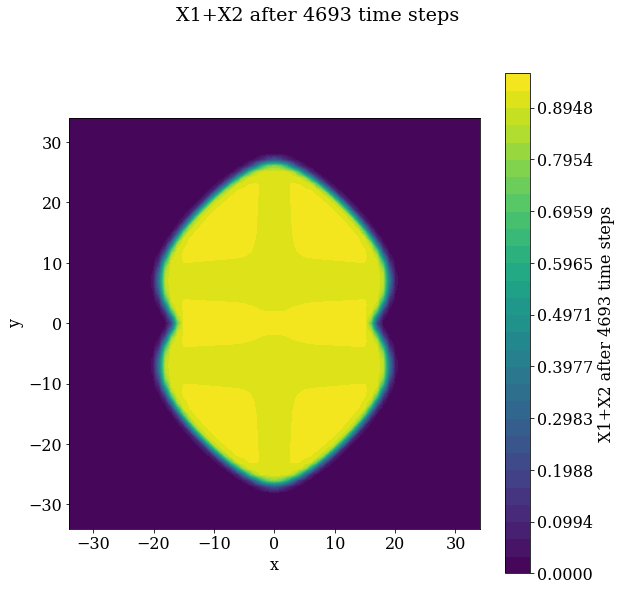

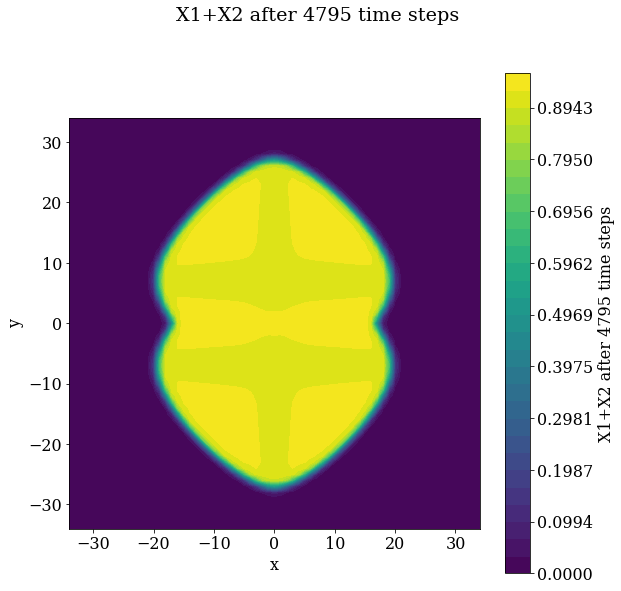

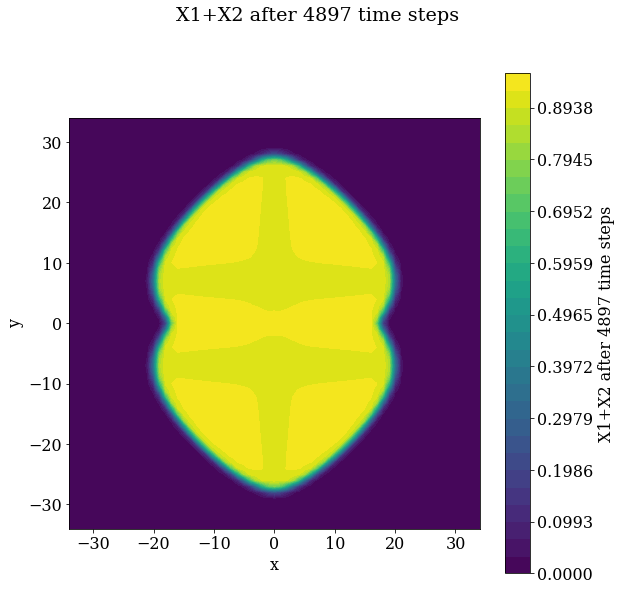

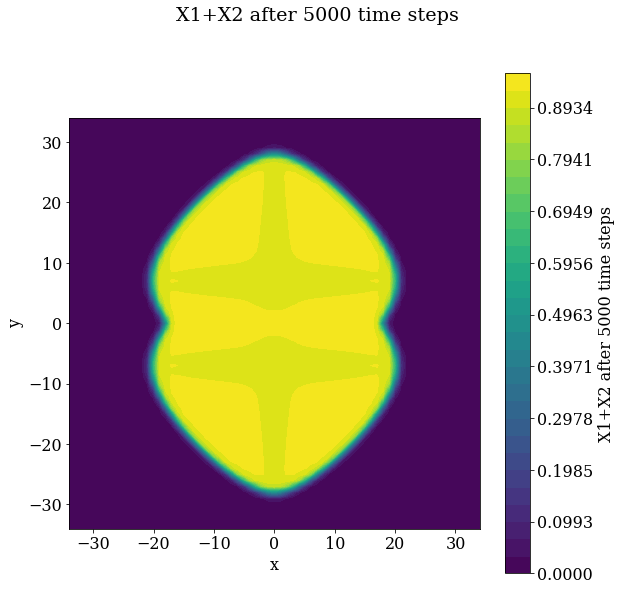

In [36]:
print("Plotting figures for X1 & X2 growth")
for i in np.linspace(0,5000,num=50,dtype=int):
    fig=pyplot.figure(figsize=(9.2,9.2))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]+X1_hist[i]), num=30) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X2_hist[i]+X1_hist[i], levels=levels)
    fig.suptitle('X1+X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X1+X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    fig.savefig('X1 n X2 %d.jpg'%i)
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


In [ ]:
print("Plotting figures for X2 growth")
for i in range(int(nt)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    #pyplot.grid()
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]), num=30) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X2_hist[i], levels=levels)
    fig.suptitle('X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

In [ ]:

############# Animation ################

from matplotlib import animation
from IPython.display import HTML

In [ ]:
import winsound
duration = 5000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

(array([34, 35, 35, 35, 36, 36, 36], dtype=int64),
 array([29, 28, 29, 30, 28, 29, 30], dtype=int64))

0
1
2
3
4


1

In [37]:
dx

1.3369565217391304

array([-5.        , -4.82758621, -4.65517241, -4.48275862, -4.31034483,
       -4.13793103, -3.96551724, -3.79310345, -3.62068966, -3.44827586,
       -3.27586207, -3.10344828, -2.93103448, -2.75862069, -2.5862069 ,
       -2.4137931 , -2.24137931, -2.06896552, -1.89655172, -1.72413793,
       -1.55172414, -1.37931034, -1.20689655, -1.03448276, -0.86206897,
       -0.68965517, -0.51724138, -0.34482759, -0.17241379,  0.        ,
        0.17241379,  0.34482759,  0.51724138,  0.68965517,  0.86206897,
        1.03448276,  1.20689655,  1.37931034,  1.55172414,  1.72413793,
        1.89655172,  2.06896552,  2.24137931,  2.4137931 ,  2.5862069 ,
        2.75862069,  2.93103448,  3.10344828,  3.27586207,  3.44827586,
        3.62068966,  3.79310345,  3.96551724,  4.13793103,  4.31034483,
        4.48275862,  4.65517241,  4.82758621,  5.        ])

In [15]:

x=np.linspace(-int(gridx/2),int(gridx/2),num=gridx,dtype=int)  #grid positions --> e.g. for 369 grids, numbering would be -184,-183,..,0,..,183,184
y=np.linspace(-int(gridy/2),int(gridy/2),num=gridy,dtype=int)

In [33]:
for i in np.linspace(1,10,num=2,dtype=int):
    print(i)

1
10
